In [65]:
import json
import warnings
import numpy as np
import pandas as pd
from modules.bootstrap import *
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from modules.minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler

# ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# load the data
path = "C:\\Users\\Samsung\\OneDrive\\Ícaro Augusto\\Portfolio\\deeplearning_chemicalengineering\\0_data\\som_studies\\data_rotaA.csv"
data = pd.read_csv(path, index_col=[0])

In [3]:
# define the columns that will be used in the SOM
x_cols = ['x_glic_et', 'x_cell_glic', 'eta_cell_orgsolv', 'capex_f1_A',
          'raw_mat_price', 'enzyme_load', 'lign_price', 'et_price']

# define the target column
target = 'msp'

# sample x and y
x = data[x_cols]
y = data[[target]]

In [4]:
# scale the features and fit SOM
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x)

x_sc = scaler.transform(x)

# determine the grid size
N = int(np.sqrt(5 * np.sqrt(x_sc.shape[0]))) 
print(f'Map Size: {N}')

Map Size: 18


In [5]:
# analyze the effect of the winning neuron influence
def analyze_winning_neuron(top_n, x_sc, y, x_cols, target):
    influence = range(1, N)
    lowest_msp = []
    lowest_msp_std = []
    for n in influence:
        msp_i = []
        msp_std_i = []
        for _ in range(100):

            som = MiniSom(x=N, y=N, input_len=x_sc.shape[1],
                    sigma=n, learning_rate=0.5)
            som.random_weights_init(x_sc)
            som.train_random(x_sc, num_iteration=200)

            # calculate the distance map and find the 
            # coordinates of the winning neurons
            dists = som.distance_map()

            # get winning neurons for each sample
            dist_list = []
            winning = []
            for i in range(x_sc.shape[0]):

                # get winning neuron coordinates
                coord = som.winner(x=x_sc[i])
                winning.append(coord)

                # get distance
                dist_list.append(dists[coord])

            # add the winning neurons to the data
            x_data = pd.DataFrame(scaler.inverse_transform(x_sc), columns=x_cols)
            x_data['winning'] = winning

            # append the target column
            x_data[target] = y

            top_n_neurons = x_data['winning'].value_counts().index[:top_n]

            # sample data for top winning neurons
            x_data_top = x_data[x_data['winning'].isin(top_n_neurons)]

            # append the mean of msp to the list
            msp_i.append(x_data_top[target].mean())
            msp_std_i.append(x_data_top[target].std())

        # get the winning neurons with the lowest msp
        lowest_msp.append(np.mean(msp_i))
        lowest_msp_std.append(np.mean(msp_std_i))

    return lowest_msp, influence, lowest_msp_std

In [6]:
# try the distribution for Top 5 neurons
lowest_msp_5, influence_5, lowest_msp_std_5 = analyze_winning_neuron(5, x_sc, y, x_cols, target)

In [7]:
# try the distribution for Top 3 neurons
lowest_msp_3, influence_3, lowest_msp_std_3 = analyze_winning_neuron(3, x_sc, y, x_cols, target)

In [8]:
# try the distribution for Top 1 neurons
lowest_msp_1, influence_1, lowest_msp_std_1 = analyze_winning_neuron(1, x_sc, y, x_cols, target)

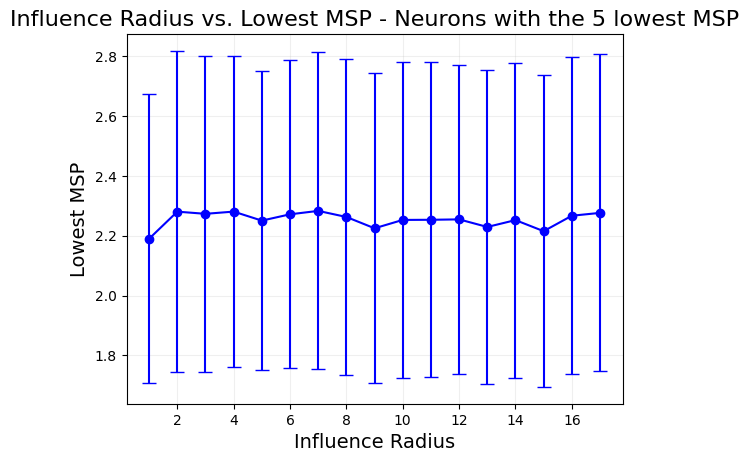

In [9]:
# plot the influence of the winning neurons
plt.errorbar(influence_5, lowest_msp_5, fmt='o-', yerr=lowest_msp_std_5, capsize=5, color='blue')
plt.xlabel('Influence Radius', size=14)
plt.ylabel('Lowest MSP', size=14)
plt.title('Influence Radius vs. Lowest MSP - Neurons with the 5 lowest MSP', size=16)
plt.grid(True, alpha=0.2)
plt.show()

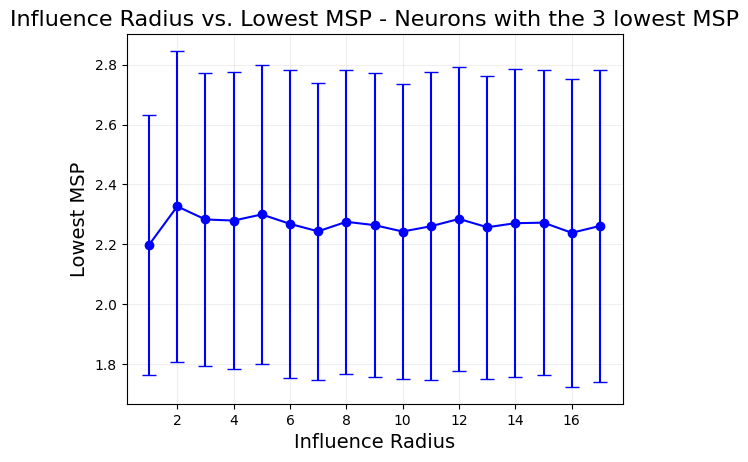

In [10]:
# plot the influence of the winning neurons
plt.errorbar(influence_3, lowest_msp_3, fmt='o-', yerr=lowest_msp_std_3, capsize=5, color='blue')
plt.xlabel('Influence Radius', size=14)
plt.ylabel('Lowest MSP', size=14)
plt.title('Influence Radius vs. Lowest MSP - Neurons with the 3 lowest MSP', size=16)
plt.grid(True, alpha=0.2)
plt.show()

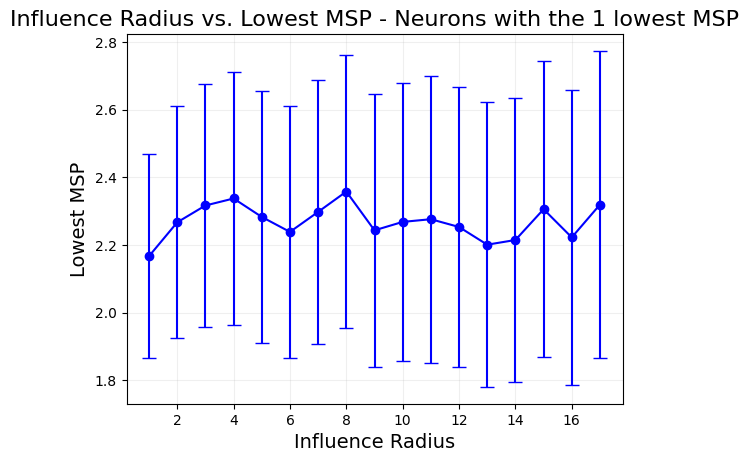

In [11]:
# plot the influence of the winning neurons
plt.errorbar(influence_1, lowest_msp_1, fmt='o-', yerr=lowest_msp_std_1, capsize=5, color='blue')
plt.xlabel('Influence Radius', size=14)
plt.ylabel('Lowest MSP', size=14)
plt.title('Influence Radius vs. Lowest MSP - Neurons with the 1 lowest MSP', size=16)
plt.grid(True, alpha=0.2)
plt.show()

- all cases seem to produce the same result. Hence, we'll chose the neighborhood = 1 neuron and will get the neuron with the lowest average MSP.

In [12]:
# fit a SOM with the best influence radius (n=1)
som = MiniSom(x=N, y=N, input_len=x_sc.shape[1], sigma=1, learning_rate=0.5)
som.random_weights_init(x_sc)
som.train_random(x_sc, num_iteration=200)

In [13]:
# get the distance map
dists = som.distance_map()

In [14]:
# get winning neurons for each sample
dist_list = []
winning = []
for i in range(x_sc.shape[0]):

    # get winning neuron coordinates
    coord = som.winner(x=x_sc[i])
    winning.append(coord)

    # get distance
    dist_list.append(dists[coord])

# add the winning neurons to the data
x_data = pd.DataFrame(scaler.inverse_transform(x_sc), columns=x_cols)
x_data['winning'] = winning
x_data['dist'] = dist_list

# append the target column
x_data[target] = y

In [15]:
x_data.sort_values(by='dist', inplace=True)
x_data.head()

,x_glic_et,x_cell_glic,eta_cell_orgsolv,capex_f1_A,raw_mat_price,enzyme_load,lign_price,et_price,winning,dist,msp
386,0.968793,0.816932,0.937457,308.857781,64.406270,0.013792,774.367649,0.335219,"(17, 13)",0.206654,3.006894
3047,0.947452,0.784555,0.919772,311.868353,73.021038,0.011682,732.102918,0.340238,"(17, 13)",0.206654,3.453847
126,0.944667,0.831054,0.921760,284.493784,68.926248,0.012638,679.412138,0.408174,"(17, 13)",0.206654,2.833552
3626,0.957430,0.819481,0.910071,263.321060,61.992048,0.013220,706.527391,0.431969,"(17, 13)",0.206654,2.474059
775,0.938240,0.769143,0.926321,266.808839,66.399174,0.013609,716.848396,0.445632,"(17, 13)",0.206654,2.808873


In [16]:
x_data.tail()

,x_glic_et,x_cell_glic,eta_cell_orgsolv,capex_f1_A,raw_mat_price,enzyme_load,lign_price,et_price,winning,dist,msp
201,0.944785,0.794957,0.836992,301.461342,69.681102,0.016771,724.784008,0.424697,"(10, 14)",0.985874,3.619049
3254,0.939561,0.794172,0.834142,296.981428,63.569406,0.015569,824.472935,0.426797,"(10, 14)",0.985874,3.262462
425,0.911205,0.890533,0.923295,213.023170,74.632975,0.007633,1012.290668,0.461563,"(9, 12)",1.000000,1.462845
4886,0.914882,0.890684,0.946530,227.963571,78.280842,0.010714,1075.900622,0.527277,"(9, 12)",1.000000,1.454311
4505,0.932336,0.870315,0.934870,207.376667,73.003275,0.011240,1021.914471,0.449984,"(9, 12)",1.000000,1.489559


- MSP does not have any evident variation between the farthest neurons when compared to the more common neurons. Let's check the correlation.

In [17]:
# checking correlation matrix
x_data.drop(columns='winning').corr(method='spearman')

,x_glic_et,x_cell_glic,eta_cell_orgsolv,capex_f1_A,raw_mat_price,enzyme_load,lign_price,et_price,dist,msp
x_glic_et,1.000000,0.024912,-0.011844,-0.013577,-0.008301,-0.012894,0.014164,-0.027326,0.009042,-0.143163
x_cell_glic,0.024912,1.000000,0.024135,0.008034,-0.013179,-0.003830,-0.008200,-0.011149,0.004389,-0.375884
eta_cell_orgsolv,-0.011844,0.024135,1.000000,0.001058,-0.016940,0.012952,0.036264,-0.008833,-0.010342,-0.248083
capex_f1_A,-0.013577,0.008034,0.001058,1.000000,-0.009071,0.004549,-0.001599,-0.009303,0.012811,0.637708
raw_mat_price,-0.008301,-0.013179,-0.016940,-0.009071,1.000000,-0.023596,-0.005059,-0.003629,0.094265,0.218841
enzyme_load,-0.012894,-0.003830,0.012952,0.004549,-0.023596,1.000000,-0.021621,-0.007685,0.092208,0.239689
lign_price,0.014164,-0.008200,0.036264,-0.001599,-0.005059,-0.021621,1.000000,-0.012282,0.037509,-0.329618
et_price,-0.027326,-0.011149,-0.008833,-0.009303,-0.003629,-0.007685,-0.012282,1.000000,0.002253,-0.331828
dist,0.009042,0.004389,-0.010342,0.012811,0.094265,0.092208,0.037509,0.002253,1.000000,0.032178
msp,-0.143163,-0.375884,-0.248083,0.637708,0.218841,0.239689,-0.329618,-0.331828,0.032178,1.000000


- the correlation matrix shows that the average MSP is not correlated with the average distances of the winning neurons.
- let's try to understand if the the lower MSPs are located in any specific neuron

In [18]:
x_data.sort_values(by='msp', inplace=True)
x_data.head()

,x_glic_et,x_cell_glic,eta_cell_orgsolv,capex_f1_A,raw_mat_price,enzyme_load,lign_price,et_price,winning,dist,msp
4240,0.974757,0.790703,0.915443,168.424902,57.586318,0.007447,785.156454,0.640377,"(5, 0)",0.499596,0.661344
1759,0.948451,0.788339,0.922957,173.807082,63.148341,0.008929,1068.896071,0.550031,"(5, 12)",0.770118,0.759267
4826,0.974807,0.774633,0.937110,184.739313,68.087285,0.008341,1051.519551,0.609234,"(9, 7)",0.686998,0.769471
852,0.959144,0.838080,0.906651,177.330898,56.463158,0.011390,914.917369,0.585051,"(5, 0)",0.499596,0.784837
3724,0.955540,0.752105,0.882512,177.215849,61.673194,0.008738,972.568421,0.649295,"(8, 0)",0.543262,0.799336


In [29]:
# check how many samples are in each winning neuron
# for MSP lower than a certain threshold
MAX_MSP = 1.96
x_data[x_data['msp'] < MAX_MSP]['winning'].value_counts().head(10)

winning
(9, 7)      34
(4, 17)     26
(6, 5)      23
(15, 16)    23
(5, 12)     23
(17, 10)    23
(13, 13)    23
(14, 10)    22
(14, 5)     22
(1, 7)      22
Name: count, dtype: int64

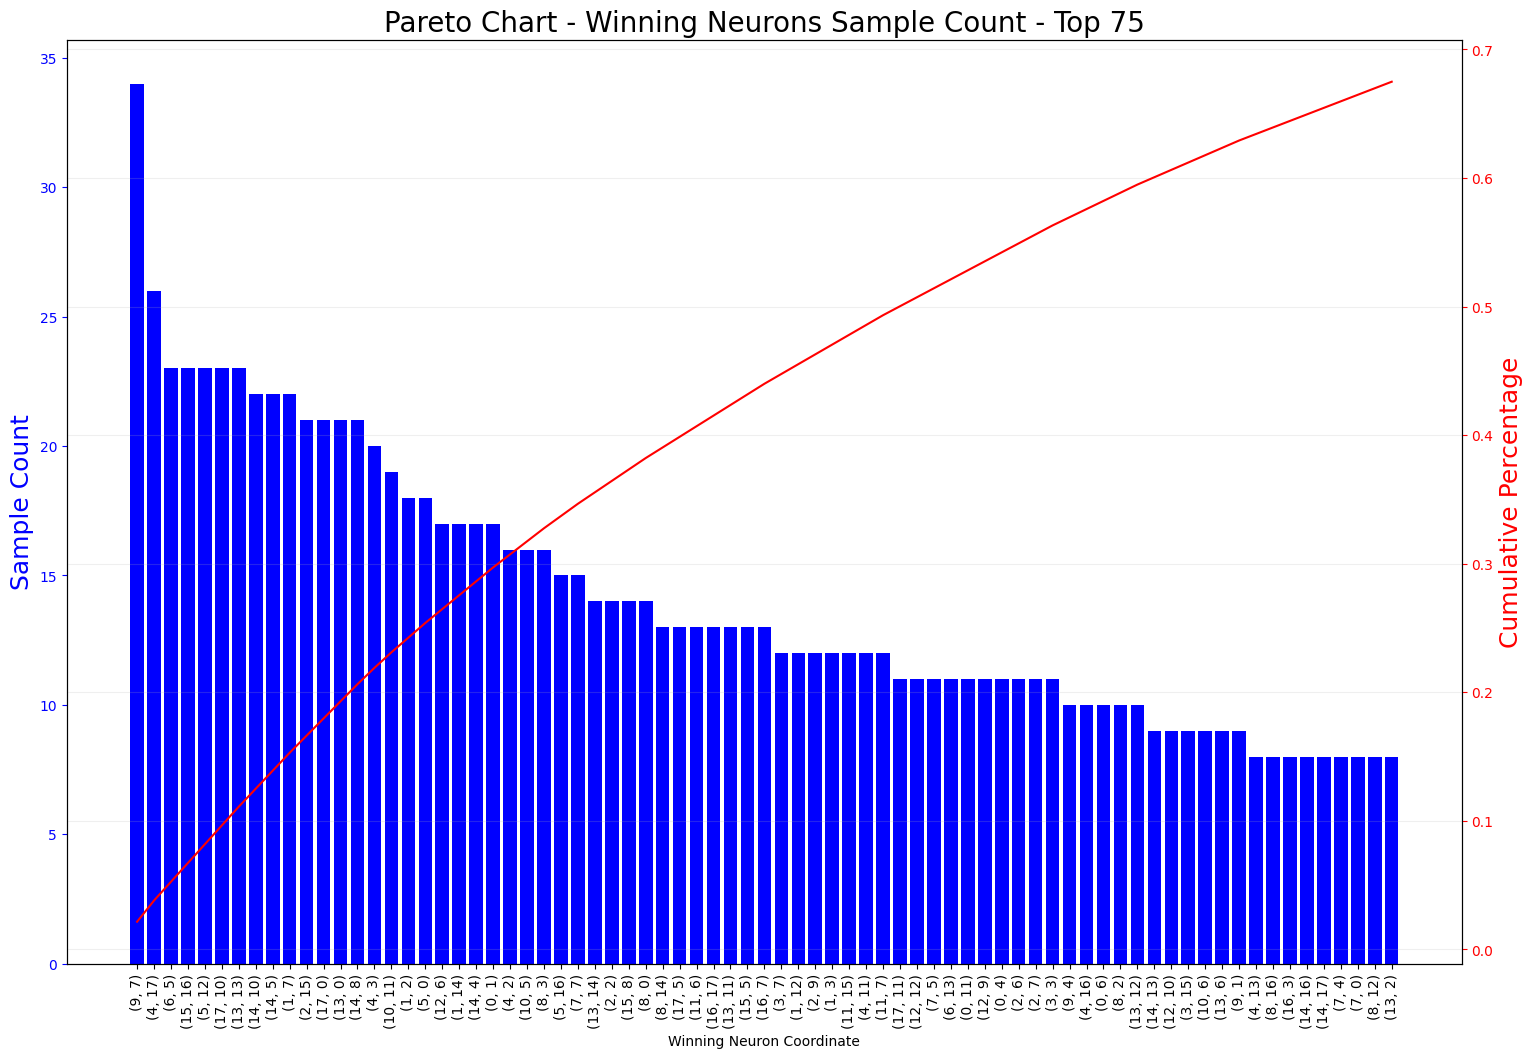

In [52]:
# count the samples in each winning neuron
winining = x_data[x_data['msp'] < MAX_MSP]['winning'].value_counts()
x = range(len(winining))
TOP_N = 75

# plot a Pareto chart with the winning neurons sample counts in the primary axis and the 
# cumulative percentage in the secondary axis
fig, ax1 = plt.subplots(figsize=(18, 12))
ax1.bar(x[:TOP_N], winining.head(TOP_N), color='blue')
ax1.set_xlabel('Winning Neuron Coordinate')
ax1.set_ylabel('Sample Count', color='blue', size=18)
ax1.tick_params('y', colors='blue')
ax1.set_xticks(x[:TOP_N])
ax1.set_xticklabels(winining.head(TOP_N).index, rotation=90)
ax1.set_title(f'Pareto Chart - Winning Neurons Sample Count - Top {TOP_N}', size=20)
ax2 = ax1.twinx()
ax2.plot(x[:TOP_N], (winining.cumsum()/winining.sum())[:TOP_N], color='red')
ax2.set_ylabel('Cumulative Percentage', color='red', size=18)
ax2.tick_params('y', colors='red')
plt.grid(True, alpha=0.2)
plt.show()

In [30]:
# what % of the samples are below the threshold
x_data[x_data['msp'] < MAX_MSP].shape[0] / x_data.shape[0]

0.315

- apparently, there are some neurons that appear more than other. Let's check their average MSP

In [31]:
# check average and std of MSP for each winning neuron that appear when MSP is lower than a certain threshold
x_data[x_data['msp'] < MAX_MSP].groupby('winning')['msp'].agg(['mean', 'std']).dropna().sort_values(by='mean')


,mean,std
winning,,
"(12, 9)",1.228885,0.227908
"(5, 12)",1.235548,0.192652
"(5, 0)",1.266608,0.348249
"(12, 12)",1.310167,0.154113
"(17, 7)",1.341778,0.284816
...,...,...
"(10, 9)",1.912255,0.035199
"(4, 8)",1.916717,0.035761
"(6, 15)",1.917146,0.044217


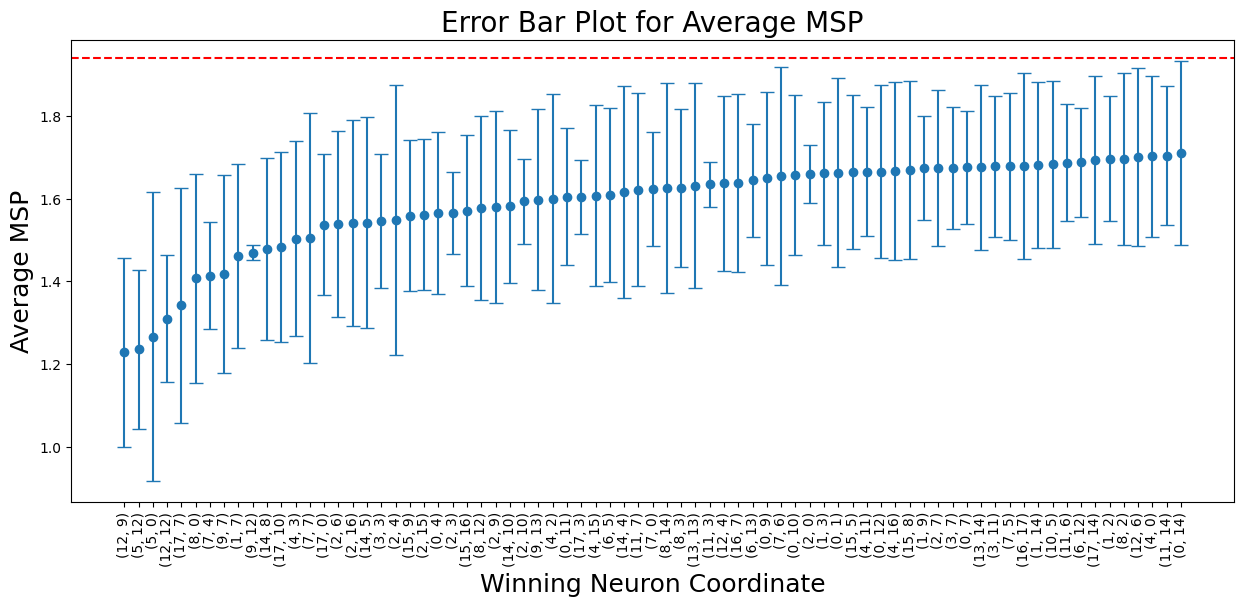

In [54]:
error = x_data[x_data['msp'] < MAX_MSP].groupby('winning')['msp'].agg(['mean', 'std']).dropna().sort_values(by='mean')

# Calculate the mean and standard deviation
mean = error['mean']
std = error['std']
xlabels = error.index
top=75

# Set the x-axis values
x = range(len(mean))

# Plot the error bar
plt.figure(figsize=(15, 6))
plt.errorbar(x[:top], mean.head(top), yerr=std.head(top), fmt='o', capsize=5)

# Add labels and title
plt.xlabel('Winning Neuron Coordinate', size=18)
plt.ylabel('Average MSP', size=18)
plt.title('Error Bar Plot for Average MSP', size=20)
plt.xticks(x[:top], xlabels[:top], rotation=90)
plt.axhline(y=1.94, color='red', linestyle='--')

# Show the plot
plt.show()

- even if we take the top 50, the MSP is statistically lower than the PCA benchmark

In [33]:
# get the samples that are in the top 50 winning neurons
LIMIT_WINNING_NEURONS = 1000

def analyze_representativity(x_data, LIMIT_WINNING_NEURONS):
    top_data = x_data[x_data['winning'].isin(mean.index[:LIMIT_WINNING_NEURONS])]
    return top_data.shape[0] / x_data.shape[0]

In [34]:
fraction = []
for i in range(1, mean.shape[0]):
    fraction.append(analyze_representativity(x_data, i))

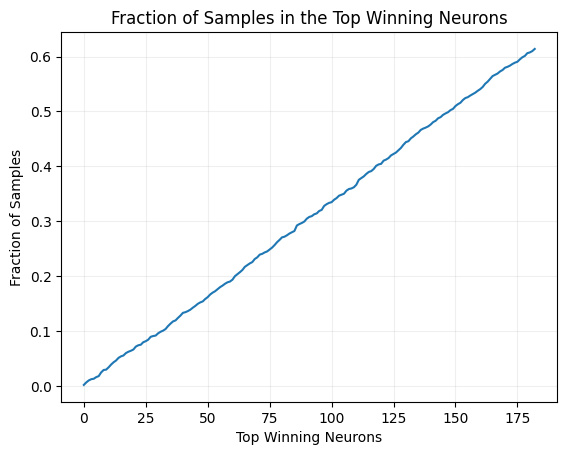

In [35]:
# plot the fraction of samples that are in the top neurons
plt.plot(fraction, '-')
plt.xlabel('Top Winning Neurons')
plt.ylabel('Fraction of Samples')
plt.title('Fraction of Samples in the Top Winning Neurons')
plt.grid(True, alpha=0.2)
plt.show()

In [36]:
# make the bootstrap analysis for the top neurons
def evaluate_risk(x_data, top_neurons, target):
    
    top_data = x_data[x_data['winning'].isin(mean.index[:top_neurons])]
    avg = bootstrap(top_data[target])
    lower, upper = np.percentile(avg, [2.5, 97.5])
    return np.mean(avg), lower, upper


risk, risk_lower, risk_upper = [], [], []
for i in range(1, mean.shape[0]):
    avg, lower, upper = evaluate_risk(x_data, i, target)
    risk.append(avg)
    risk_lower.append(lower)
    risk_upper.append(upper)

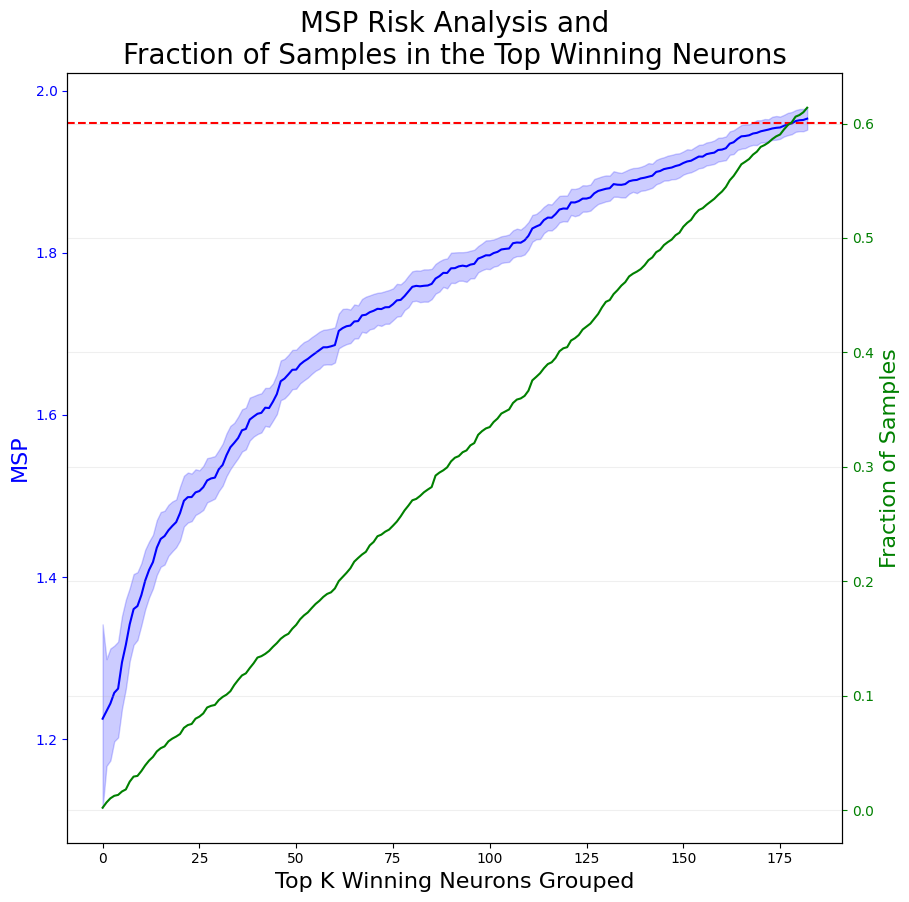

In [64]:
# plot the risk analysis and the representative fraction in second y-axis
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.plot(risk, 'b-')
ax1.fill_between(range(len(risk)), risk_lower, risk_upper, color='blue', alpha=0.2)
ax1.set_xlabel('Top K Winning Neurons Grouped', size=16)
ax1.set_ylabel('MSP', color='b', size=16)
ax1.axhline(y=1.96, color='red', linestyle='--')
ax1.tick_params('y', colors='b')
second = ax1.twinx()
second.plot(fraction, 'g-')
second.set_ylabel('Fraction of Samples', color='g', size=16)
second.tick_params('y', colors='g')
plt.title('MSP Risk Analysis and\nFraction of Samples in the Top Winning Neurons', size=20)
plt.grid(True, alpha=0.2)
plt.show()

In [38]:
# get the samples that are in the top 100 winning neurons
LIMIT_WINNING_NEURONS = 100
top_data = x_data[x_data['winning'].isin(mean.index[:LIMIT_WINNING_NEURONS])]

# check statistics for process variables in the top neurons
top_data.drop(columns=['winning', 'dist']).describe()

,x_glic_et,x_cell_glic,eta_cell_orgsolv,capex_f1_A,raw_mat_price,enzyme_load,lign_price,et_price,msp
count,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000
mean,0.953820,0.794071,0.908729,212.691181,68.458772,0.011126,842.090859,0.502163,1.796821
std,0.020315,0.048546,0.037953,25.231254,5.508192,0.002730,119.228861,0.073008,0.359730
min,0.901193,0.655911,0.805177,160.017481,55.958510,0.006001,540.544750,0.270158,0.661344
25%,0.939088,0.759138,0.882021,194.365690,64.476876,0.009092,759.402197,0.452586,1.552537
50%,0.953957,0.795298,0.908624,210.943611,68.559264,0.010732,839.958686,0.500021,1.777540
75%,0.968464,0.830322,0.936473,228.566280,72.615362,0.012657,934.722509,0.552375,2.043142
max,0.997792,0.896378,0.997024,318.215820,81.983978,0.019750,1092.811946,0.713198,3.120651


In [66]:
# do a hypothesis test to check if the MSP in the top neurons is higher than the benchmark
BENCHMARK = 1.96
ttest_1samp(top_data['msp'], BENCHMARK)

TtestResult(statistic=-18.52613339630334, pvalue=8.011401274848723e-70, df=1667)